## Entrainement de nos modèles sur la base RAVDESS

In [1]:
#!pip install pymrmr
#!pip install audiomentations
#!pip install pydub

In [2]:
import os
import re
import joblib
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# from pydub import AudioSegment
# from pydub.effects import normalize
# from sklearn.preprocessing import MinMaxScaler

### Définition des fonctions utiles

In [6]:
# Fonction de precession du fichier en vue de le normaliser
def process_audio(file_path):
    y, sr = librosa.load(file_path)
    y, _ = librosa.effects.trim(y)

    normalized_y = librosa.util.normalize(y)

    return normalized_y, sr

In [7]:
# Fonctions de traitement des fichiers audios
def extract_features(normalized_y, sr, max_len=100):
    mfccs = librosa.feature.mfcc(y=normalized_y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=normalized_y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=normalized_y, sr=sr)

    mfccs = librosa.util.fix_length(mfccs, size = max_len, axis=1)
    chroma = librosa.util.fix_length(chroma, size = max_len, axis=1)
    spectral_contrast = librosa.util.fix_length(spectral_contrast, size = max_len, axis=1)

    flat_mfccs = np.ravel(mfccs)
    flat_chroma = np.ravel(chroma)
    flat_spectral_contrast = np.ravel(spectral_contrast)

    return flat_mfccs, flat_chroma, flat_spectral_contrast

In [8]:
# Fonction d'augmentation des fichiers audios
def augment_audio(y, sr):
    augment = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.2),
        PitchShift(min_semitones=-2, max_semitones=2),
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015)
    ])

    augmented_y = augment(samples=y, sample_rate=sr)

    return augmented_y

In [9]:
# Dans notre contexte, nous avons décidé de nous concentrer sur la prédiction d'une émotion: la colère
def is_anger(emotion):
    return 1 if emotion == "anger" else 0

In [7]:
audio_directory = "data/audio_speech_emotion"

audio_files = []
emotions = []
mfccs_list = []
chroma_list = []
spectral_contrast_list = []

emotion_mapping = {
    'ang': 'anger',
    'cal': 'calm',
    'dis': 'disgust',
    'fea': 'fear',
    'hap': 'happiness',
    'neu': 'neutral',
    'sad': 'sadness',
    'sur': 'surprise'
}

In [8]:
for filename in tqdm(os.listdir(audio_directory)):
    if filename.endswith(".wav"):
        match = re.search(r'^([a-zA-Z]{3})', filename)
        emotion = emotion_mapping.get(match.group(1), 'unknown')

        file_path = os.path.join(audio_directory, filename)

        normalized_y, sr = process_audio(file_path)

        original_mfccs, original_chroma, original_spectral_contrast = extract_features(normalized_y, sr)

        augmented_y = augment_audio(normalized_y, sr)
        augmented_mfccs, augmented_chroma, augmented_spectral_contrast = extract_features(augmented_y, sr)

        audio_files.extend([filename, f"augmented_{filename}"])
        emotions.extend([emotion, emotion])
        mfccs_list.extend([original_mfccs, augmented_mfccs])
        chroma_list.extend([original_chroma, augmented_chroma])
        spectral_contrast_list.extend([original_spectral_contrast, augmented_spectral_contrast])



df = pd.DataFrame({
    'Audio_File': audio_files,
    'Emotion': emotions,
    'MFCCs': mfccs_list,
    'Chroma': chroma_list,
    'Spectral_Contrast': spectral_contrast_list
})

  0%|          | 0/1380 [00:00<?, ?it/s]

100%|██████████| 1380/1380 [02:28<00:00,  9.29it/s]


In [9]:
df.head()

,Audio_File,Emotion,MFCCs,Chroma,Spectral_Contrast
0,hap_N_kids_rep2_M5.wav,happiness,"[-560.8875, -557.3468, -557.6999, -560.072, -5...","[0.99280536, 0.9239153, 0.86961377, 0.5242816,...","[20.288140537780052, 16.049922218454988, 17.91..."
1,augmented_hap_N_kids_rep2_M5.wav,happiness,"[-560.8875, -557.3468, -557.6999, -560.072, -5...","[0.99280536, 0.9239153, 0.86961377, 0.5242816,...","[20.288140537780052, 16.049922218454988, 17.91..."
2,fea_S_dogs_rep2_F22.wav,fear,"[-557.0281, -550.8854, -544.0535, -483.4463, -...","[0.43459034, 0.3906931, 0.39205012, 0.7074244,...","[13.510801619773137, 16.844586394879578, 15.92..."
3,augmented_fea_S_dogs_rep2_F22.wav,fear,"[-293.92853, -255.03133, -253.6468, -249.69287...","[0.7218535, 0.9674026, 1.0, 1.0, 1.0, 0.749644...","[10.010549207763423, 7.792056258532215, 6.5056..."
4,fea_N_kids_rep2_M11.wav,fear,"[-564.0849, -559.55365, -559.0394, -560.73395,...","[0.82920116, 0.669364, 0.6859306, 0.76664114, ...","[10.980496795417464, 23.34173214011679, 16.894..."


In [10]:
df[df["Emotion"] != "unknown"].head()

,Audio_File,Emotion,MFCCs,Chroma,Spectral_Contrast
0,hap_N_kids_rep2_M5.wav,happiness,"[-560.8875, -557.3468, -557.6999, -560.072, -5...","[0.99280536, 0.9239153, 0.86961377, 0.5242816,...","[20.288140537780052, 16.049922218454988, 17.91..."
1,augmented_hap_N_kids_rep2_M5.wav,happiness,"[-560.8875, -557.3468, -557.6999, -560.072, -5...","[0.99280536, 0.9239153, 0.86961377, 0.5242816,...","[20.288140537780052, 16.049922218454988, 17.91..."
2,fea_S_dogs_rep2_F22.wav,fear,"[-557.0281, -550.8854, -544.0535, -483.4463, -...","[0.43459034, 0.3906931, 0.39205012, 0.7074244,...","[13.510801619773137, 16.844586394879578, 15.92..."
3,augmented_fea_S_dogs_rep2_F22.wav,fear,"[-293.92853, -255.03133, -253.6468, -249.69287...","[0.7218535, 0.9674026, 1.0, 1.0, 1.0, 0.749644...","[10.010549207763423, 7.792056258532215, 6.5056..."
4,fea_N_kids_rep2_M11.wav,fear,"[-564.0849, -559.55365, -559.0394, -560.73395,...","[0.82920116, 0.669364, 0.6859306, 0.76664114, ...","[10.980496795417464, 23.34173214011679, 16.894..."


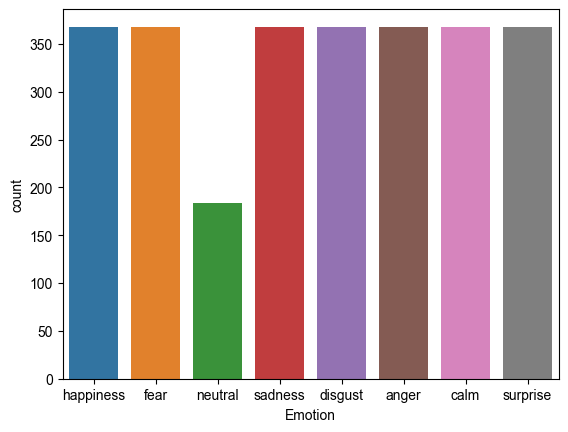

In [11]:
# Voyons la répartition de chaque émotion
sns.countplot(df, x="Emotion", hue="Emotion")
sns.set(rc={'figure.figsize':(16,5)})

In [12]:
df["anger"] = df['Emotion'].apply(is_anger)

In [13]:
# Dataframe de chaque categories de features

mfccs_list_columns = [f'mfccs_{i}' for i in range(len(mfccs_list[0]))]
df_mfccs = pd.DataFrame(mfccs_list, columns=mfccs_list_columns)

chroma_list_columns = [f'chroma_{i}' for i in range(len(chroma_list[0]))]
df_chroma = pd.DataFrame(chroma_list, columns=chroma_list_columns)

spectral_contrast_list_columns = [f'spectral_contrast_{i}' for i in range(len(spectral_contrast_list[0]))]
df_spectral_contrast = pd.DataFrame(spectral_contrast_list, columns=spectral_contrast_list_columns)

In [14]:
# Dataset d'exploitation avec features et sans features selection
features = pd.concat([df["Audio_File"],df_mfccs, df_chroma,df_spectral_contrast,df["anger"]], axis=1)
features = features.sample(frac = 1) # A changer si le dataset est trop grand
features.head()

,Audio_File,mfccs_0,mfccs_1,mfccs_2,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,...,spectral_contrast_691,spectral_contrast_692,spectral_contrast_693,spectral_contrast_694,spectral_contrast_695,spectral_contrast_696,spectral_contrast_697,spectral_contrast_698,spectral_contrast_699,anger
2553,augmented_sad_N_kids_rep2_M19.wav,-496.131989,-502.878296,-554.580322,-560.882935,-564.876709,-560.990967,-533.951172,-518.549805,-517.950684,...,50.357200,47.780708,47.614068,45.011954,46.727640,45.263660,44.187338,42.062269,45.656439,0
680,neu_N_dogs_rep2_M11.wav,-526.456848,-536.880188,-544.775818,-538.701111,-532.397522,-531.385193,-530.200500,-521.222229,-515.974243,...,48.538915,49.597100,49.059049,47.633302,47.765071,49.465280,45.017533,45.191926,45.040913,0
2673,augmented_hap_S_kids_rep1_M21.wav,-531.031982,-526.899048,-527.289490,-528.679077,-532.421814,-533.274536,-533.072388,-531.442017,-511.999817,...,46.156403,49.734907,50.369967,48.140274,46.282210,23.064848,17.906901,0.000000,0.000000,0
466,sad_S_dogs_rep1_M5.wav,-410.638489,-435.932281,-494.195587,-485.730377,-482.678223,-514.587708,-539.962891,-540.088013,-535.196533,...,48.440705,50.224607,50.483991,49.695511,50.426406,50.240737,50.065165,47.766611,47.521293,0
266,ang_N_dogs_rep2_F10.wav,-512.329590,-500.959167,-509.489777,-509.875092,-513.951965,-521.680359,-521.358521,-525.217957,-527.668701,...,50.342173,47.660225,47.664690,48.087817,47.777988,49.081599,48.548343,53.989945,50.488128,1


In [15]:
features.shape

(2760, 3202)

In [16]:
# Sauverage du dataset en parquet
features.to_parquet('data/datasets/features.parquet', index=False)

## Entrainement des models

In [ ]:
# Chargelent du dataset
# features = pd.read_parquet('data/datasets/features.parquet')

### Définition des modèles

In [48]:
def train_model_knn(X_train, y_train):
    model = KNeighborsClassifier()
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_knn = grid_search.best_estimator_

    return best_knn

def train_model_svc(X_train, y_train):
    model = SVC()
    model.fit(X_train, y_train)

    return model

def train_model_dt(X_train, y_train):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    return model

In [49]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

### Séparation des données en données de train, test et validation

In [50]:
X = features.drop(columns=['Audio_File', 'anger'])
y = features["anger"].values

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [20]:
X_train_valid.shape, X_test.shape

((2208, 3200), (552, 3200))

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=21)

In [22]:
X_train.shape, X_valid.shape

((1987, 3200), (221, 3200))

### Entrainement des modèles

In [52]:
knn_model = train_model_knn(X_train, y_train)
evaluate_model(knn_model, X_test, y_test)

/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.

Accuracy: 0.9004
Precision: 0.8881
Recall: 0.9004


/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [24]:
svm_model = train_model_svc(X_train, y_train)
evaluate_model(svm_model, X_test, y_test)

/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.

Accuracy: 0.8804
Precision: 0.7752
Recall: 0.8804


/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
dtc_model = train_model_dt(X_train, y_train)
evaluate_model(dtc_model, X_test, y_test)

/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Accuracy: 0.8533
Precision: 0.8340
Recall: 0.8533


/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [53]:
# Sauvegarde des modeles
print("🔄 Models saving ...")
joblib.dump(knn_model, 'models/knn_model.pkl')
joblib.dump(svm_model, 'models/svm_model.pkl')
joblib.dump(dtc_model, 'models/dtc_model.pkl')
print("✅ Models saved successfully !")

🔄 Models saving ...
✅ Models saved successfully !


## Validation des modèles

In [55]:
predictions = knn_model.predict(X_valid)

/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [56]:
y_valid

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0])

In [57]:
compare = pd.DataFrame({'Actual': y_valid, 'Predicted': predictions, 'OK ?': y_valid == predictions})
compare.head(20)

,Actual,Predicted,OK ?
0,0,0,True
1,0,0,True
2,1,0,False
3,0,0,True
4,1,0,False
5,0,0,True
6,0,0,True
7,1,1,True
8,0,0,True
9,0,0,True


## Test des modèles sur d'autres fichiers audios

In [12]:
# Chargement des modeles
knn_model = joblib.load('models/knn_model.pkl')
svm_model = joblib.load('models/svm_model.pkl')
dtc_model = joblib.load('models/dtc_model.pkl')

In [13]:
def predict_emotion(audio_test_file):
    normalized_y, sr = process_audio(audio_test_file)
    flat_mfccs, flat_chroma, flat_spectral_contrast = extract_features(normalized_y, sr)

    flat_mfccs = np.array(flat_mfccs).reshape(1, -1)
    flat_chroma = np.array(flat_chroma).reshape(1, -1)
    flat_spectral_contrast = np.array(flat_spectral_contrast).reshape(1, -1)

    flat_features = np.concatenate((flat_mfccs, flat_chroma, flat_spectral_contrast), axis=1)

    knn_prediction = knn_model.predict(flat_features)
    svm_prediction = svm_model.predict(flat_features)
    dtc_prediction = dtc_model.predict(flat_features)

    print("Audio File is anger: ", audio_test_file)
    print("KNN: ", knn_prediction == 1)
    print("SVM: ", svm_prediction == 1)
    print("DTC: ", dtc_prediction == 1)

In [14]:
audio_file = "data/test_data/a09.wav"
predict_emotion(audio_file)

Audio File is anger:  data/test_data/a09.wav
KNN:  [False]
SVM:  [False]
DTC:  [False]


/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [15]:
audio_file = "data/audio_speech_emotion/ang_N_dogs_rep1_F2.wav"
predict_emotion(audio_file)™

Audio File is anger:  data/audio_speech_emotion/ang_N_dogs_rep1_F2.wav
KNN:  [ True]
SVM:  [False]
DTC:  [ True]


/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Volumes/Second/EFREI/ING 3/APPLICATION OF BIG DATA/.app-bd/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
